In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import collections

Using TensorFlow backend.


In [2]:
# csv 파일 읽기
df = pd.read_csv("creditcard.csv")

# 492 fraudulent transactions, 284,315 normal transactions.
# 0.172% of transactions were fraud.
print(df.Class.value_counts())

0    284315
1       492
Name: Class, dtype: int64


In [3]:
df.loc[df.Class == 0, 'Normal'] = 1
df.loc[df.Class == 1, 'Normal'] = 0

# Rename 'Class' to 'Fraud'
# Class -> Fraud 로 명 변환
df = df.rename(columns = {'Class' : 'Fraud'})


# max column 수 설정
pd.set_option('display.max_columns',  101)
# print(df.head())

# Create dataframes of only Fraud and Normal transactions.
Fraud = df[df.Fraud == 1]
Normal = df[df.Normal == 1]
print('Fraud  : ', len(Fraud))
print('Normal : ', len(Normal))

Fraud  :  492
Normal :  284315


In [4]:
# Set X_train equal to 80% of the fraudulent transactions.
FraudSample  = Fraud.sample(frac=0.8)
NormalSample = Normal.sample(frac=0.8)
count_Frauds = len(FraudSample)
# Add 80% of the normal transactions to X_train.
for_train = pd.concat([FraudSample, NormalSample], axis=0)

# X_test contains all the transaction not in X_train.
for_test = df.loc[~df.index.isin(for_train.index)]

print('len(for_train)  : ',len(for_train))
print('len(for_test)   : ',len(for_test))

len(for_train)  :  227846
len(for_test)   :  56961


In [5]:
#Shuffle the dataframes so that the training is done in a random order.
for_train = for_train.sample(frac=1).reset_index(drop=True)
for_test = for_test.sample(frac=1).reset_index(drop=True)
#for_test = np.random.shuffle(for_test)

# Add our target features to y_train and y_test.
X_train = for_train.drop(['Fraud', 'Normal'], axis = 1)
# Drop target features from X_train and X_test.
#  Fraud, Normal 컬럼 drop
y_train = for_train[['Fraud', 'Normal']]

# Add our target features to y_train and y_test.
X_test = for_test.drop(['Fraud', 'Normal'], axis = 1)
# Drop target features from X_train and X_test.
#  Fraud, Normal 컬럼 drop
y_test = for_test[['Fraud', 'Normal']]

#Check to ensure all of the training/testing dataframes are of the correct length
print('len(X_train) : ',len(X_train))
print('len(y_train) : ',len(y_train))
print('len(X_test)  : ',len(X_test))
print('len(y_test)  : ',len(y_test))

len(X_train) :  227846
len(y_train) :  227846
len(X_test)  :  56961
len(y_test)  :  56961


In [6]:
# In [26]
'''
Due to the imbalance in the data, ratio will act as an equal weighting system for our model. 
By dividing the number of transactions by those that are fraudulent, ratio will equal the value that when multiplied
by the number of fraudulent transactions will equal the number of normal transaction. 
Simply put: # of fraud * ratio = # of normal
'''

ratio = len(X_train) / count_Frauds
print('ratio :', ratio)

y_train.Fraud *= ratio*3
y_test.Fraud *= ratio*3

#Names of all of the features in X_train.
features = X_train.columns.values
print('features : ',features)

#Transform each feature in features so that it has a mean of 0 and standard deviation of 1;
#this helps with training the neural network.
for feature in features:
    mean, std = df[feature].mean(), df[feature].std()
    # print('feature :',feature , 'mean : ', mean , 'std :', std)
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std

ratio : 578.2893401015228
features :  ['Time' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8' 'V9' 'V10' 'V11' 'V12'
 'V13' 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20' 'V21' 'V22' 'V23' 'V24'
 'V25' 'V26' 'V27' 'V28' 'Amount']


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [7]:
'''
Train the Neural Net
'''

# In [28]
# Split the testing data into validation and testing sets
split = int(len(y_test)/2)
print('split : ', split)

train_x = X_train.as_matrix()
train_y = y_train.as_matrix()
valid_x = X_test.as_matrix()[:split]
valid_y = y_test.as_matrix()[:split]
test_x = X_test.as_matrix()[split:]
test_y = y_test.as_matrix()[split:]

print('type(inputX)  : ', type(train_x))
print('type(X_train) : ', type(X_train))

print('y_train.Normal.value_counts() :',y_train.Normal.value_counts())
print('y_train.Fraud.value_counts() :',y_train.Fraud.value_counts())

print('y_test.Normal.value_counts() :',y_test.Normal.value_counts())
print('y_test.Fraud.value_counts() :',y_test.Fraud.value_counts())

print('C valid_y', np.where(valid_y[:, 0] > 0, 1, 0).sum())
print('C test_y ', np.where(test_y[:, 0] > 0, 1, 0).sum())

print('inputX :',train_x.shape)
print('inputY :',train_y.shape)
print('valid_x :',valid_x.shape)
print('valid_y :',valid_y.shape)
print('test_x :',test_x.shape)
print('test_y :',test_y.shape)

split :  28480
type(inputX)  :  <class 'numpy.ndarray'>
type(X_train) :  <class 'pandas.core.frame.DataFrame'>
y_train.Normal.value_counts() : 1.0    227452
0.0       394
Name: Normal, dtype: int64
y_train.Fraud.value_counts() : 0.00000       227452
1734.86802       394
Name: Fraud, dtype: int64
y_test.Normal.value_counts() : 1.0    56863
0.0       98
Name: Normal, dtype: int64
y_test.Fraud.value_counts() : 0.00000       56863
1734.86802       98
Name: Fraud, dtype: int64
C valid_y 41
C test_y  57
inputX : (227846, 30)
inputY : (227846, 2)
valid_x : (28480, 30)
valid_y : (28480, 2)
test_x : (28481, 30)
test_y : (28481, 2)


In [8]:
# Confusion Matrix
def get_conf_rate(model, testX, testY):
    # 모델 예측
    predicted_y = model.predict(testX)

    # compare predicted_y & testY
    conf_cnt = collections.defaultdict(int)
    for pr_y, real_y in zip(predicted_y, testY):
        conf = np.argmax(pr_y), np.argmax(real_y)
        conf_cnt[conf] += 1

    # 0번방 == Fraud, 1번방 == Normal
    TP = conf_cnt[(0 ,0)]
    FN = conf_cnt[(1, 0)]
    TN = conf_cnt[(1, 1)]
    FP = conf_cnt[(0, 1)]

    Acc = (TP + TN) / (TP + TN + FP + FN)
    try:
        Precision = TP / (TP + FP)
    except: # 학습초기에 decision by zero 발생 가능 (범죄라고 판단한 건수가 zero인 상황
        Precision = 0
      
    try:
        Recall = TP / (TP + FN)
    except:
        Recall = 0
        raise

    print('TP :', TP, ' FN :',FN , ' TN :', TN, ' FP :', FP)
    print('Recall: %.3f, Precision: %.3f, Acc: %.3f' % (Recall, Precision, Acc))
    return Recall, Precision, Acc

In [9]:
# Callback Class
class mykerasCB(keras.callbacks.Callback):
    def __init__(self):
        super(mykerasCB, self).__init__()
        self.hist = [] # confusion matrix값 (비율)을 기록하기 위한 것

    def on_epoch_end(self, arga, argb):
        # arga: 49 -- epoch count
        # argb: {'loss': 288.23164164477009, 'acc': 0.98443246759461789}
        #print('self.model', self.model)
        #print('arga :', arga)
        #print('argb :', argb)
        if arga % 10 == 9: # 10번 epoch 마다 출력해보기
          confusion = get_conf_rate(model, test_x, test_y)
          self.hist.append(confusion)
  

In [10]:
      
# Number of input nodes.
input_nodes = train_x.shape[1]

# Multiplier maintains a fixed ratio of nodes between each layer.
mulitplier = 1.5

# Number of nodes in each hidden layer
hidden_nodes1 = 18
hidden_nodes2 = round(hidden_nodes1 * mulitplier)
hidden_nodes3 = round(hidden_nodes2 * mulitplier)

# In [31]
# Parameters
training_epochs = 50             # should be 2000, it will timeout when uploading
training_dropout = 0.9          # drop out
display_step = 1                # 10
n_samples = y_train.shape[0]
batch_size = 2048
learning_rate = 0.005           # 하이퍼파라미터

In [11]:
print('======================================================')
print('======================  Keras   ======================')
print('======================================================')

# 모델 구성하기
model = Sequential()
model.add(Dense(hidden_nodes1, input_dim=input_nodes, activation='relu'))
model.add(Dense(hidden_nodes2, activation='tanh'))
model.add(Dense(hidden_nodes3, activation='relu'))
model.add(Dense(hidden_nodes3, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

# Callback Class 선언
cb = mykerasCB()

# 모델 학습과정 설정하기
model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['accuracy'])

======================  Keras   ======================


In [12]:
# 모델 학습시키기
hist = model.fit(train_x, train_y, epochs=training_epochs, batch_size=batch_size,
                 callbacks = [cb], verbose=1)

Epoch 1/50
227846/227846 [==============================] - 1s 6us/step - loss: 2600.1959 - acc: 0.1708
Epoch 2/50
227846/227846 [==============================] - 1s 5us/step - loss: 2599.6401 - acc: 0.8462
Epoch 3/50
227846/227846 [==============================] - 1s 5us/step - loss: 2599.5367 - acc: 0.8856
Epoch 4/50
227846/227846 [==============================] - 1s 5us/step - loss: 2599.5036 - acc: 0.9060
Epoch 5/50
227846/227846 [==============================] - 1s 5us/step - loss: 2599.4873 - acc: 0.9187
Epoch 6/50
227846/227846 [==============================] - 1s 5us/step - loss: 2599.4703 - acc: 0.9190
Epoch 7/50
227846/227846 [==============================] - 1s 5us/step - loss: 2599.4552 - acc: 0.9200
Epoch 8/50
227846/227846 [==============================] - 1s 5us/step - loss: 2599.4461 - acc: 0.9353
Epoch 9/50
227846/227846 [==============================] - 1s 5us/step - loss: 2599.4353 - acc: 0.9413
Epoch 10/50
223232/227846 [============================>.] - ETA

In [13]:
# 최종 confusion matrix 구하기
get_conf_rate(model, test_x, test_y)

# 모델 평가하기
loss_and_metrics = model.evaluate(valid_x, valid_y, batch_size=batch_size)
print('loss_and_metrics : ' + str(loss_and_metrics))

TP : 44  FN : 6  TN : 27371  FP : 1060
Recall: 0.880, Precision: 0.040, Acc: 0.963
28480/28480 [==============================] - 0s 3us/step
loss_and_metrics : [2533.6159086420294, 0.96327247191011234]


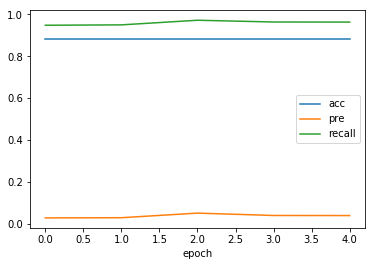

======================  Keras   ======================


In [14]:
fig, ax =  plt.subplots()

acc = [h[0] for h in cb.hist]
pre = [h[1] for h in cb.hist]
recall = [h[2] for h in cb.hist]

ax.plot(acc, label='acc')
ax.plot(pre, label='pre')
ax.plot(recall, label='recall')

ax.set_xlabel('epoch')
ax.legend()

plt.show()

print('======================================================')
print('======================  Keras   ======================')
print('======================================================')